This script analyzes a dataset of recipes by clustering them based on various features, including both numerical (Calories, Carbohydrates, Proteins) and categorical (Health Goals, Dietary Preference, Recipe Category, Recipe Difficulty). It employs the KMeans algorithm to cluster the data, with the number of clusters pre-set for numerical features and adjusted for categorical ones, particularly setting a different cluster number for Recipe Difficulty.

For numerical features, it standardizes the data before clustering and visualizes each feature's clusters in scatter plots. Categorical features are one-hot encoded before clustering, with the resulting clusters visualized in bar plots to show the distribution of recipes across clusters.

The script also assigns cluster labels back to the original dataset for each feature, enabling a comprehensive view of how each recipe aligns with the clusters identified across all analyzed features. Finally, it aggregates recipes into clusters for each feature, presenting a summary table that lists recipes grouped by their cluster assignment, thus providing insights into the dataset's structure and potential patterns in recipe characteristics.

Silhouette Score for Calories: 0.5093


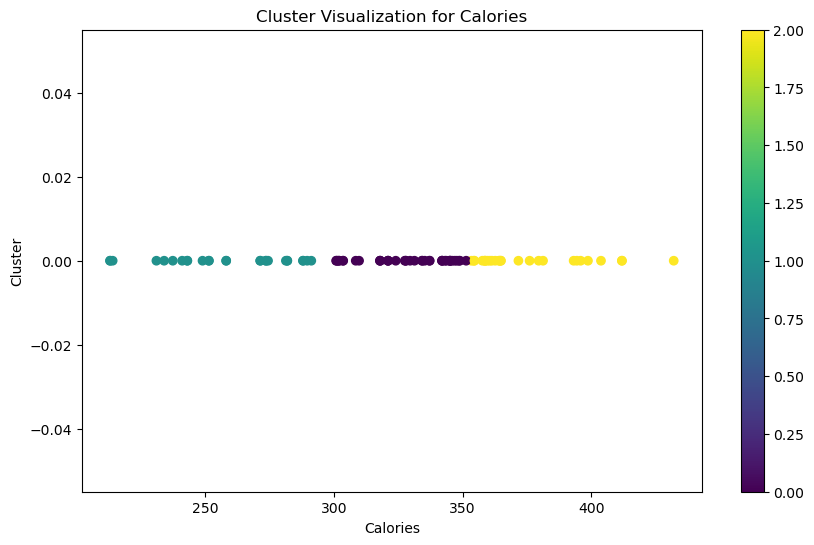

Silhouette Score for Carbohydrates: 0.5325


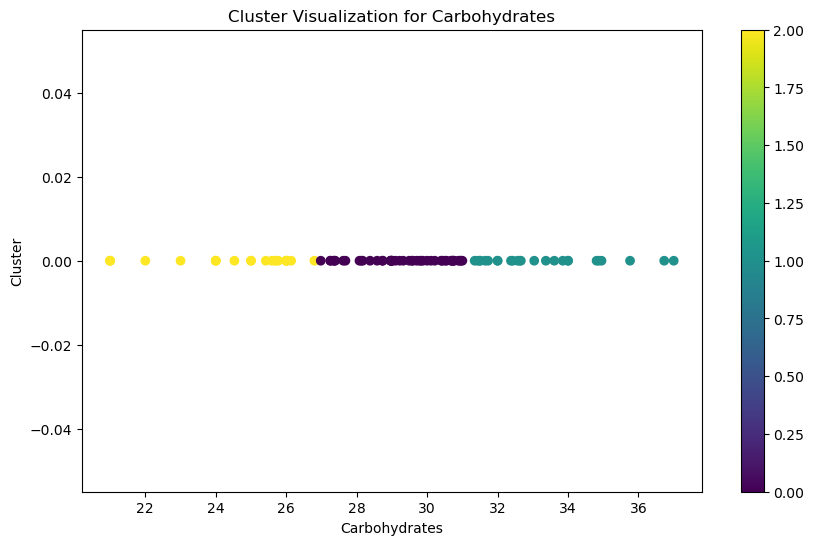

Silhouette Score for Proteins: 0.6274


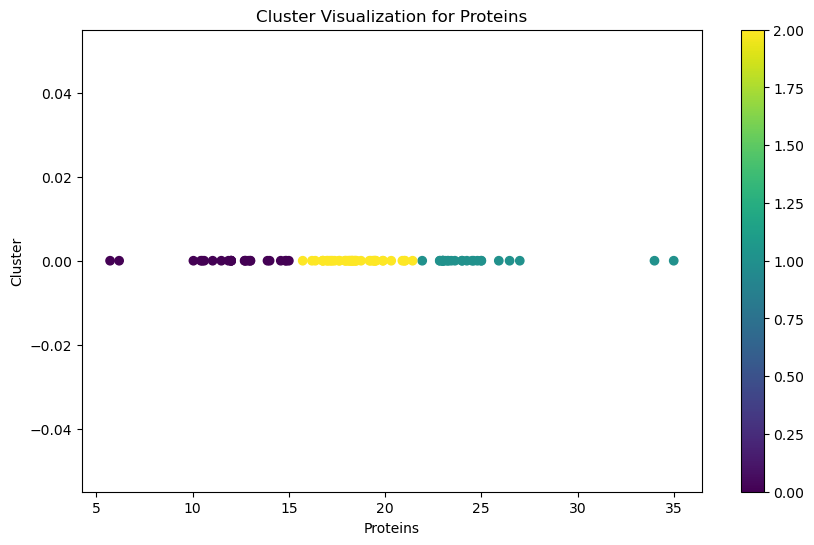

Silhouette Score for Health Goals: 0.9660


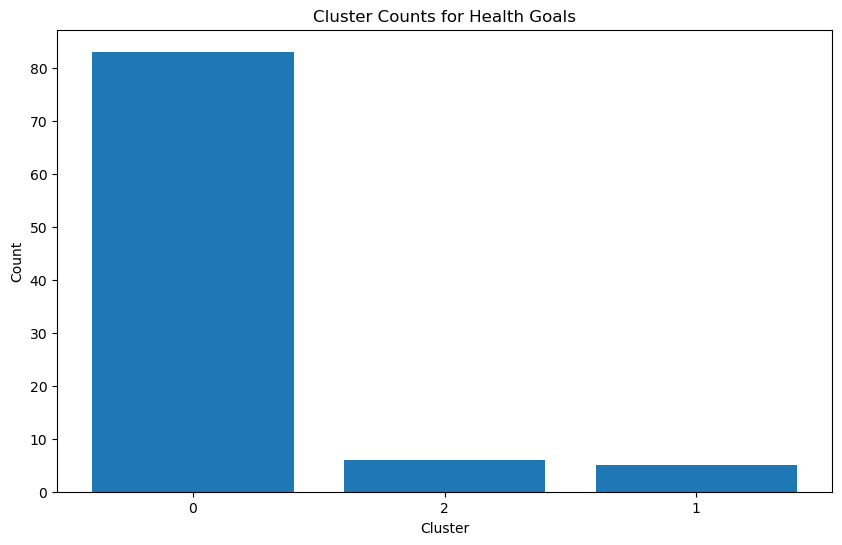

Silhouette Score for Dietary Preference: 0.9269


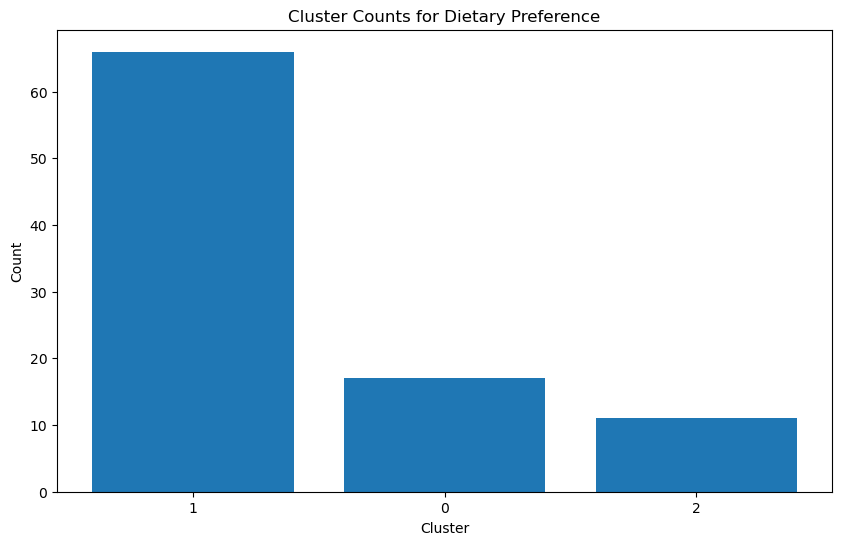

Silhouette Score for Recipe Category: 0.2855


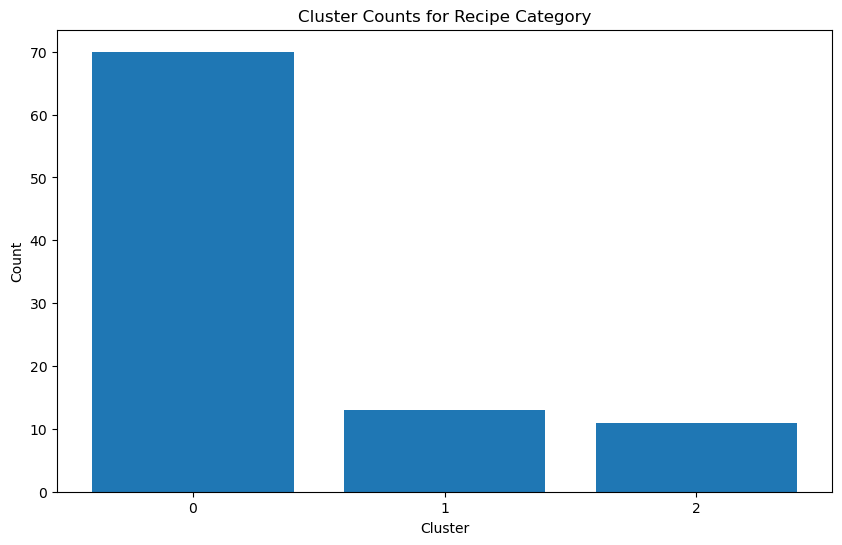

Silhouette Score for Recipe Difficulty: 1.0000


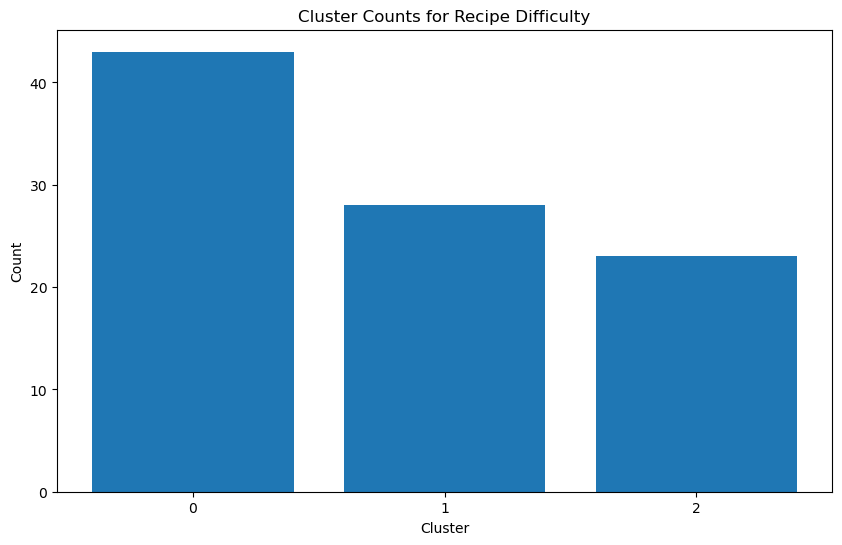

Silhouette Score for Ingredient: 0.0624


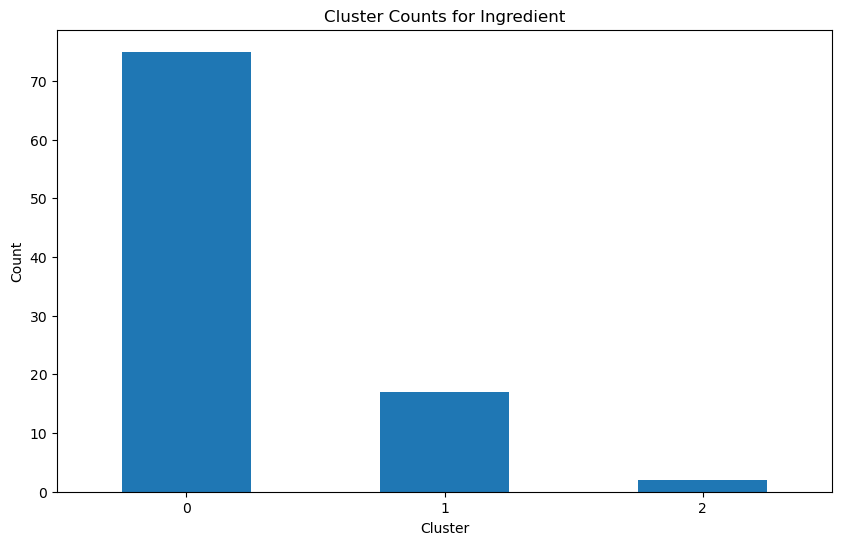

Recipes in each cluster for each feature:
                     Feature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Load the dataset
data = pd.read_csv("updated_cleaned_recipe_dataset.csv")

# Define the feature columns for clustering
numerical_features = ['Calories', 'Carbohydrates', 'Proteins']
categorical_features = ['Health Goals', 'Dietary Preference', 'Recipe Category', 'Recipe Difficulty']

# Standard Scaler for numerical data
scaler = StandardScaler()

# Set the number of clusters
k = 3  

# Function to print silhouette score
def print_silhouette_score(data, cluster_labels, feature):
    score = silhouette_score(data, cluster_labels)
    print(f"Silhouette Score for {feature}: {score:.4f}")

# Clustering for each numerical feature separately
for feature in numerical_features:
    # Standardize the numerical feature
    scaled_numerical_data = scaler.fit_transform(data[[feature]])

    # Cluster the numerical data
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_numerical_data)
    
    # Assign cluster labels to the DataFrame
    data[f'{feature}_Cluster'] = cluster_labels

    # Calculate and print silhouette score
    print_silhouette_score(scaled_numerical_data, cluster_labels, feature)

    # Visualize the clusters for the current numerical feature
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature], [0] * len(data), c=cluster_labels, cmap='viridis', marker='o')
    plt.title(f'Cluster Visualization for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Cluster')
    plt.colorbar()
    plt.show()

# Handling categorical features
for feature in categorical_features:
    # If categorical, get dummies (one-hot encode)
    encoded_feature = pd.get_dummies(data[feature])
    
    # Clustering on encoded categorical data
    kmeans_categorical = KMeans(n_clusters=k_categorical, n_init=10, random_state=42)
    cluster_labels_categorical = kmeans_categorical.fit_predict(encoded_feature.values)
    
    # Assign cluster labels to the DataFrame
    data[f'{feature}_Cluster'] = cluster_labels_categorical
    
    # Calculate and print silhouette score for categorical features
    print_silhouette_score(encoded_feature, cluster_labels_categorical, feature)

    # Bar plot for categorical features
    cluster_counts = pd.value_counts(cluster_labels_categorical)
    plt.figure(figsize=(10, 6))
    plt.bar(x=range(len(cluster_counts)), height=cluster_counts, tick_label=cluster_counts.index)
    plt.title(f'Cluster Counts for {feature}')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()

data['Ingredients_Joined'] = data['Ingredient'].apply(lambda x: ' '.join(eval(x)))
vectorizer = CountVectorizer()
ingredients_features = vectorizer.fit_transform(data['Ingredients_Joined'])

# Clustering on Ingredient feature
kmeans_ingredients = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_labels_ingredients = kmeans_ingredients.fit_predict(ingredients_features)

# Assign cluster labels to the DataFrame
data['Ingredient_Cluster'] = cluster_labels_ingredients

# Calculate and print silhouette score for Ingredient
print_silhouette_score(ingredients_features, cluster_labels_ingredients, 'Ingredient')

# Plotting the count vs. cluster graph for Ingredient
cluster_counts = pd.Series(cluster_labels_ingredients).value_counts().sort_index()
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title('Cluster Counts for Ingredient')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Create an empty list to store dataframes
clustered_recipes_dfs = []

# Ensure 'Ingredient' is correctly included in the features list
features_list = numerical_features + categorical_features + ['Ingredient']

# Iterate through each feature and its clusters
for feature in features_list:
    cluster_col_name = f'{feature}_Cluster'
    if cluster_col_name in data.columns:  # Check if the cluster column exists
        cluster_groups = data.groupby(cluster_col_name)
        for cluster_label, cluster_data in cluster_groups:
            recipes_str = ', '.join(cluster_data['Recipe'])  # Assuming 'Recipe' is the column name with recipe names
            df = pd.DataFrame({'Feature': [f'{feature} Cluster {cluster_label}'], 'Recipes': [recipes_str]})
            clustered_recipes_dfs.append(df)

# Concatenate all dataframes in the list
clustered_recipes_table = pd.concat(clustered_recipes_dfs, ignore_index=True)

# Display the table
print("Recipes in each cluster for each feature:")
print(clustered_recipes_table.to_string(index=False))